In [ ]:
library(fst)
library(data.table)
library(tidyverse)
library(lubridate)
library(stringr)
library(modeltime)
library(tidymodels)
library(rsample)
library(gridExtra)
options(repr.plot.width=15)
options(scipen=999)

In [2]:
df <- read.fst('data_serialized/transactions.fst',as.data.table=T)

## Aggregating Data

In [3]:
df[,ga_datehour := ymd_h(ga_datehour)]
name_template <- colnames(df[0])
df[,ga_datehour := as.Date(ga_datehour)]

In [4]:
dfa <- df[,lapply(.SD,function(x) ifelse(x=='',NA,x)),.SD=is.character]
dfb <- df[,.SD,.SDcols=!is.character]
df <- cbind(dfa,dfb)
                                          
rm(dfa)
rm(dfb)
gc()
                                          
setDT(df)
                                              
df <- df[,.SD,.SDcols=name_template]
df %>% head(5)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,21329420,1139.2,38541004,2058.4,21465047,1146.4
Vcells,154422152,1178.2,367226141,2801.8,362795138,2768.0


pk,ga_transactionid,ga_datehour,ga_products,ga_channels,ga_itemquantity
<int>,<chr>,<date>,<chr>,<chr>,<int>
146288072,2_50414543,2020-08-29,Product D,Facebook,1
146288071,2_50414542,2020-08-29,Product D,Organic search,1
146287503,2_50413935,2020-08-29,Product D,Organic search,1
146287504,2_50413936,2020-08-29,Product D,Organic search,1
146296436,3_65496155,2020-08-29,Product E,Google Ads,1


In [5]:
df[,date := ga_datehour]
df[,ga_datehour := NULL]
df <- df[,.(visitor_num = sum(ga_itemquantity)),by=c('date','ga_channels')]

In [6]:
df[,wday := wday(date)]
df[,yday := yday(date)]
df[,month := month(date)]
df[,saturday := +(wday==6)]
df[,sunday := +(wday==7)]

I fill NA in `ga_channels` column as 'Other'

In [7]:
df[is.na(ga_channels),ga_channels := 'Other']

### Saving Data As A Check Point

In [9]:
df %>% write.fst('data_serialized/task2_df.fst')

## Splitting Data For Each Channel

In [8]:
splitted_data <- df %>%
group_by(ga_channels) %>% 
group_split()

crm <- splitted_data[[1]]
direct <- splitted_data[[2]]
facebook <- splitted_data[[3]]
googleads <- splitted_data[[4]]
search <- splitted_data[[5]]
other <- splitted_data[[6]]
referral <- splitted_data[[7]]

rm(splitted_data)
gc()

setDT(crm)
setDT(direct)
setDT(facebook)
setDT(googleads)
setDT(search)
setDT(other)
setDT(referral)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2438117,130.3,30832804,1646.7,21994229,1174.7
Vcells,12591176,96.1,293780913,2241.4,362795138,2768.0


## Adding shift for each channel

In [108]:
crm[,shift := lag(visitor_num)]
crm[1:3]

date,ga_channels,visitor_num,wday,yday,saturday,sunday,month,shift
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
2020-08-29,CRM,2420,7,242,0,1,8,NA
2020-08-30,CRM,2611,1,243,0,0,8,2420
2020-08-31,CRM,3282,2,244,0,0,8,2611


In [109]:
direct[,shift := lag(visitor_num)]
direct[1:3]

date,ga_channels,visitor_num,wday,yday,saturday,sunday,month,shift
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
2020-08-29,Direct,337,7,242,0,1,8,NA
2020-08-30,Direct,376,1,243,0,0,8,337
2020-08-31,Direct,500,2,244,0,0,8,376


In [110]:
facebook[,shift := lag(visitor_num)]
facebook[1:3]

date,ga_channels,visitor_num,wday,yday,saturday,sunday,month,shift
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
2020-08-29,Facebook,2123,7,242,0,1,8,NA
2020-08-30,Facebook,2812,1,243,0,0,8,2123
2020-08-31,Facebook,2921,2,244,0,0,8,2812


In [111]:
googleads[,shift := lag(visitor_num)]
googleads[1:3]

date,ga_channels,visitor_num,wday,yday,saturday,sunday,month,shift
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
2020-08-29,Google Ads,21985,7,242,0,1,8,NA
2020-08-30,Google Ads,24524,1,243,0,0,8,21985
2020-08-31,Google Ads,33484,2,244,0,0,8,24524


In [112]:
search[,shift := lag(visitor_num)]
search[1:3]

date,ga_channels,visitor_num,wday,yday,saturday,sunday,month,shift
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
2020-08-29,Organic search,4938,7,242,0,1,8,NA
2020-08-30,Organic search,5878,1,243,0,0,8,4938
2020-08-31,Organic search,7915,2,244,0,0,8,5878


In [113]:
other[,shift := lag(visitor_num)]
other[1:3]

date,ga_channels,visitor_num,wday,yday,saturday,sunday,month,shift
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
2020-08-29,Other,1227,7,242,0,1,8,NA
2020-08-30,Other,1292,1,243,0,0,8,1227
2020-08-31,Other,1343,2,244,0,0,8,1292


In [114]:
referral[,shift := lag(visitor_num)]
referral[1:3]

date,ga_channels,visitor_num,wday,yday,saturday,sunday,month,shift
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
2020-08-29,Referral,389,7,242,0,1,8,NA
2020-08-30,Referral,505,1,243,0,0,8,389
2020-08-31,Referral,580,2,244,0,0,8,505


In [154]:
tablenames <- c('crm','direct','facebook','googleads','search','other','referral')

for(i in tablenames){
    eval(parse(text=sprintf('%s_plot <- plot_time_series(%s,date,visitor_num,.interactive=F) + ggtitle("%s")',i,i,toupper(i))))
}

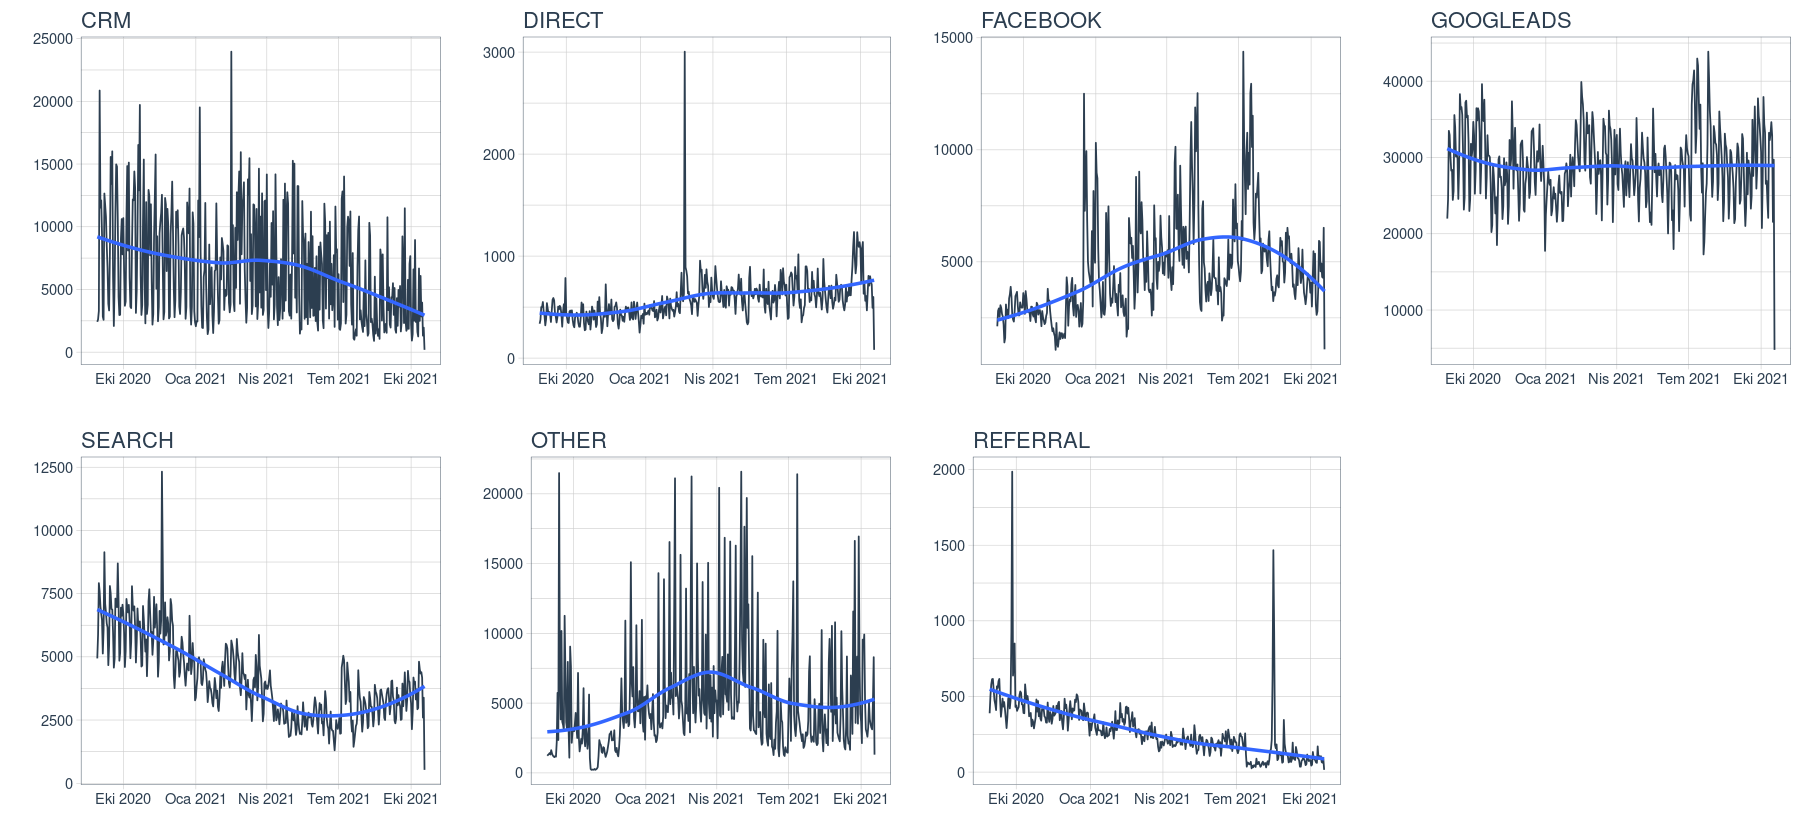

In [160]:
eval(parse(text=sprintf('plot_aggregate <- grid.arrange(%s,nrow=2)',paste0(paste0(tablenames,'_plot'),collapse = ','))))

# Modeling

## Fitting ARIMA models for each class

In [ ]:
set.seed(1453)

for(i in tablenames){
    eval(parse(text=sprintf('%s_split <- initial_time_split(%s,0.7)',i,i)))
    eval(parse(text=sprintf('%s_arima <- fit(set_engine(arima_reg(),engine="auto_arima"),visitor_num ~ shift + date + wday + saturday + sunday + yday,training(%s_split))',i,i)))
}

## Visualizing Test Set Performances

In [206]:
for(i in tablenames){
    eval(parse(text = sprintf('%s_plot_test <- ggplot(cbind(testing(%s_split),predict(%s_arima,testing(%s_split))),aes(date,visitor_num)) + geom_line(color="red")+ geom_line(aes(date,.pred),color="blue") + ggtitle("%s")',i,i,i,i,toupper(i))))
}

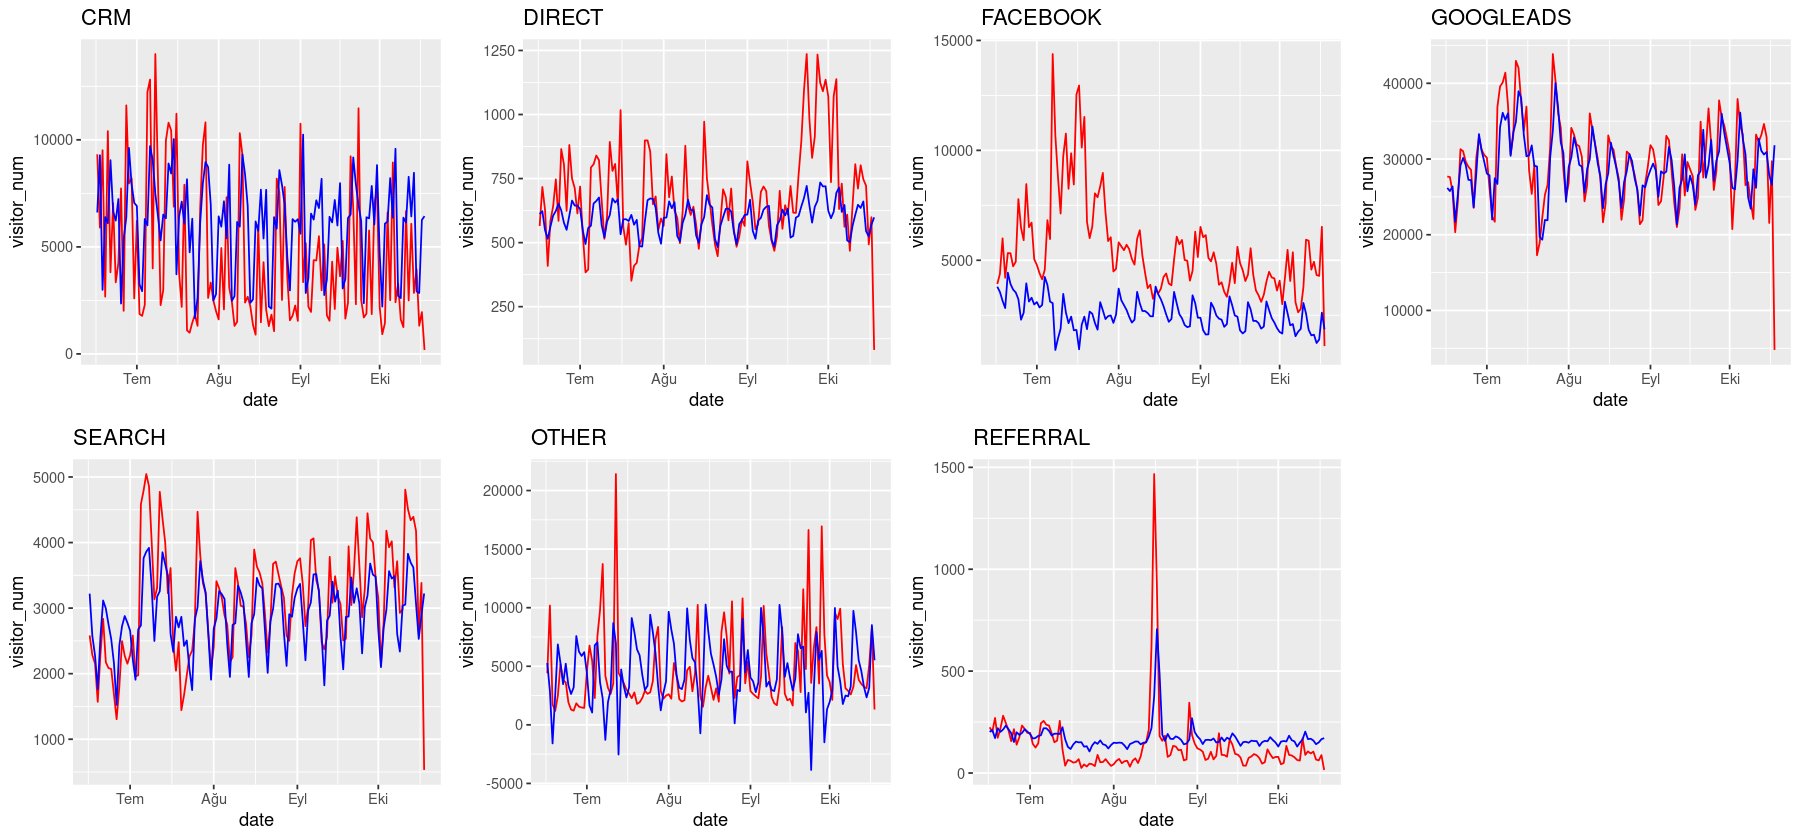

In [207]:
eval(parse(text=sprintf('plot_aggregate <- grid.arrange(%s,nrow=2)',paste0(paste0(tablenames,'_plot_test'),collapse = ','))))

## Test Set MAPE's

In [222]:
model_metric <- NULL
for(i in tablenames){
    eval(parse(text=sprintf('tahmin <- predict(%s_arima,testing(%s_split))$.pred ; obs <- testing(%s_split)$visitor_num',i,i,i)))
    eval(parse(text=sprintf('fark <- abs(tahmin - obs); ape <- fark/obs ;%s_mape <- mean(ape)',i)))
    eval(parse(text=sprintf('newrow <- data.frame(channel = "%s", test_set_mape = %s_mape)',i,i)))
    
    model_metric <- rbind(model_metric,newrow)
}

In [223]:
model_metric

channel,test_set_mape
<chr>,<dbl>
crm,1.4512534
direct,0.2113686
facebook,0.4944131
googleads,0.1293449
search,0.1922425
other,0.8413638
referral,1.0561679


# Forecasting

In [271]:
last_date <- df %>% arrange(date) %>% tail(1) %>% select(date) %>% pull

df %>% 
filter(date==last_date) %>% 
rename(shift=visitor_num) %>% 
mutate(wday = wday + 1) %>% 
mutate(date = date + 1) %>% 
mutate(yday = yday + 1) -> to_pred

to_pred

date,ga_channels,shift,wday,yday,saturday,sunday,month
<date>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
2021-10-19,Facebook,1096,3,292,0,0,10
2021-10-19,Google Ads,4783,3,292,0,0,10
2021-10-19,Other,1307,3,292,0,0,10
2021-10-19,Organic search,531,3,292,0,0,10
2021-10-19,CRM,185,3,292,0,0,10
2021-10-19,Direct,81,3,292,0,0,10
2021-10-19,Referral,15,3,292,0,0,10


Because I fitted single model for each, I am splitting them again.

In [274]:
pred_group <- to_pred %>% group_by(ga_channels) %>% group_split()

In [279]:
crm_pred <- pred_group[[1]]
direct_pred <- pred_group[[2]]
facebook_pred <- pred_group[[3]]
googleads_pred <- pred_group[[4]]
search_pred <- pred_group[[5]]
other_pred <- pred_group[[6]]
referral_pred <- pred_group[[7]]

# Predictions for 2021-10-19

In [289]:
predictions <- NULL

firstup <- function(x) {
  substr(x, 1, 1) <- toupper(substr(x, 1, 1))
  x
}

for(i in tablenames){
    eval(parse(text = sprintf('prediction <- predict(%s_arima,%s_pred)$.pred',i,i)))
    eval(parse(text = sprintf('newrow <- data.frame(ga_channel = "%s", visitor_num = prediction)',firstup(i))))
    predictions <- rbind(predictions,newrow)
}

In [290]:
predictions

ga_channel,visitor_num
<chr>,<dbl>
Crm,5385.9036
Direct,501.5073
Facebook,2803.3707
Googleads,10609.3607
Search,1977.5032
Other,7358.0239
Referral,134.0499
